# Fish Market Weight Analysis - Regression Modelling

![Alt Text](https://images.unsplash.com/photo-1611214774777-3d997a9d0e35?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NHx8ZmlzaCUyMG1hcmtldHxlbnwwfHwwfHx8MA%3D%3D&w=1000&q=80)


# Import stuff

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import optuna

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Loading and Info

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Ankit152/Fish-Market/main/Fish.csv')

df2 = pd.read_csv('https://raw.githubusercontent.com/Ankit152/Fish-Market/main/Fish.csv')

df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


## Info

* 7 cols, 1 cat, 6 numerical
* Weight as label, 6 features
* no null values, check duplicates?
* unique species? balanced dataset?
* check distribution of numericals

In [4]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


## Describe

* Weight min of 0? need to clean
* length mean +- std looks decent, not like the weight data mistake
* same for height and width, guess we have to check and atleast remove the 0 weight

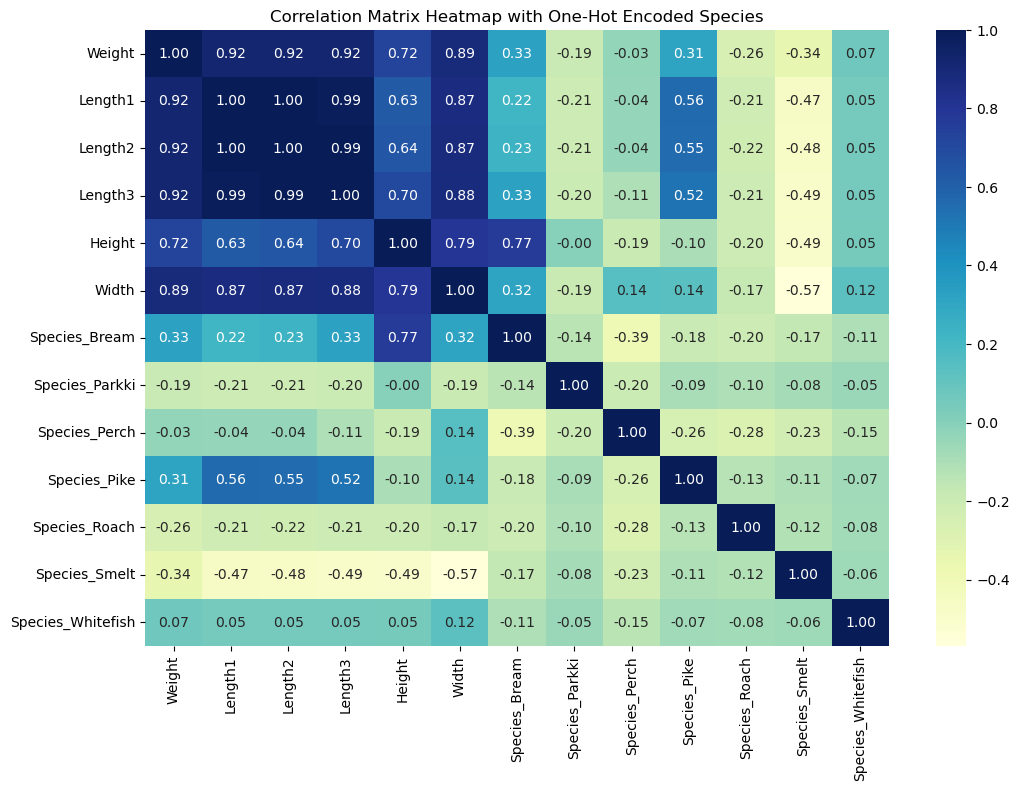

In [5]:
# OHE to show cat feature
df_encoded = pd.get_dummies(df, columns=['Species'], prefix=['Species'])

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix Heatmap with One-Hot Encoded Species")
plt.show()

## corrmatrix

* high corr between different lengths, all fishs seems to have the same shape?
* all numerical features highly correlated with weight, height with the lowest, but still at 0.72
* Bream and Pike highest correlations, heaviest fish, Roach and Smelt large negative, lightest fish

In [6]:
df.groupby('Species').agg({'Weight':'mean'}).sort_values(by = 'Weight')

,Weight
Species,
Smelt,11.178571
Roach,152.050000
Parkki,154.818182
Perch,382.239286
Whitefish,531.000000
Bream,617.828571
Pike,718.705882


Yep, turns out Smelt is by far the lightest and pike the heaviest fish

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


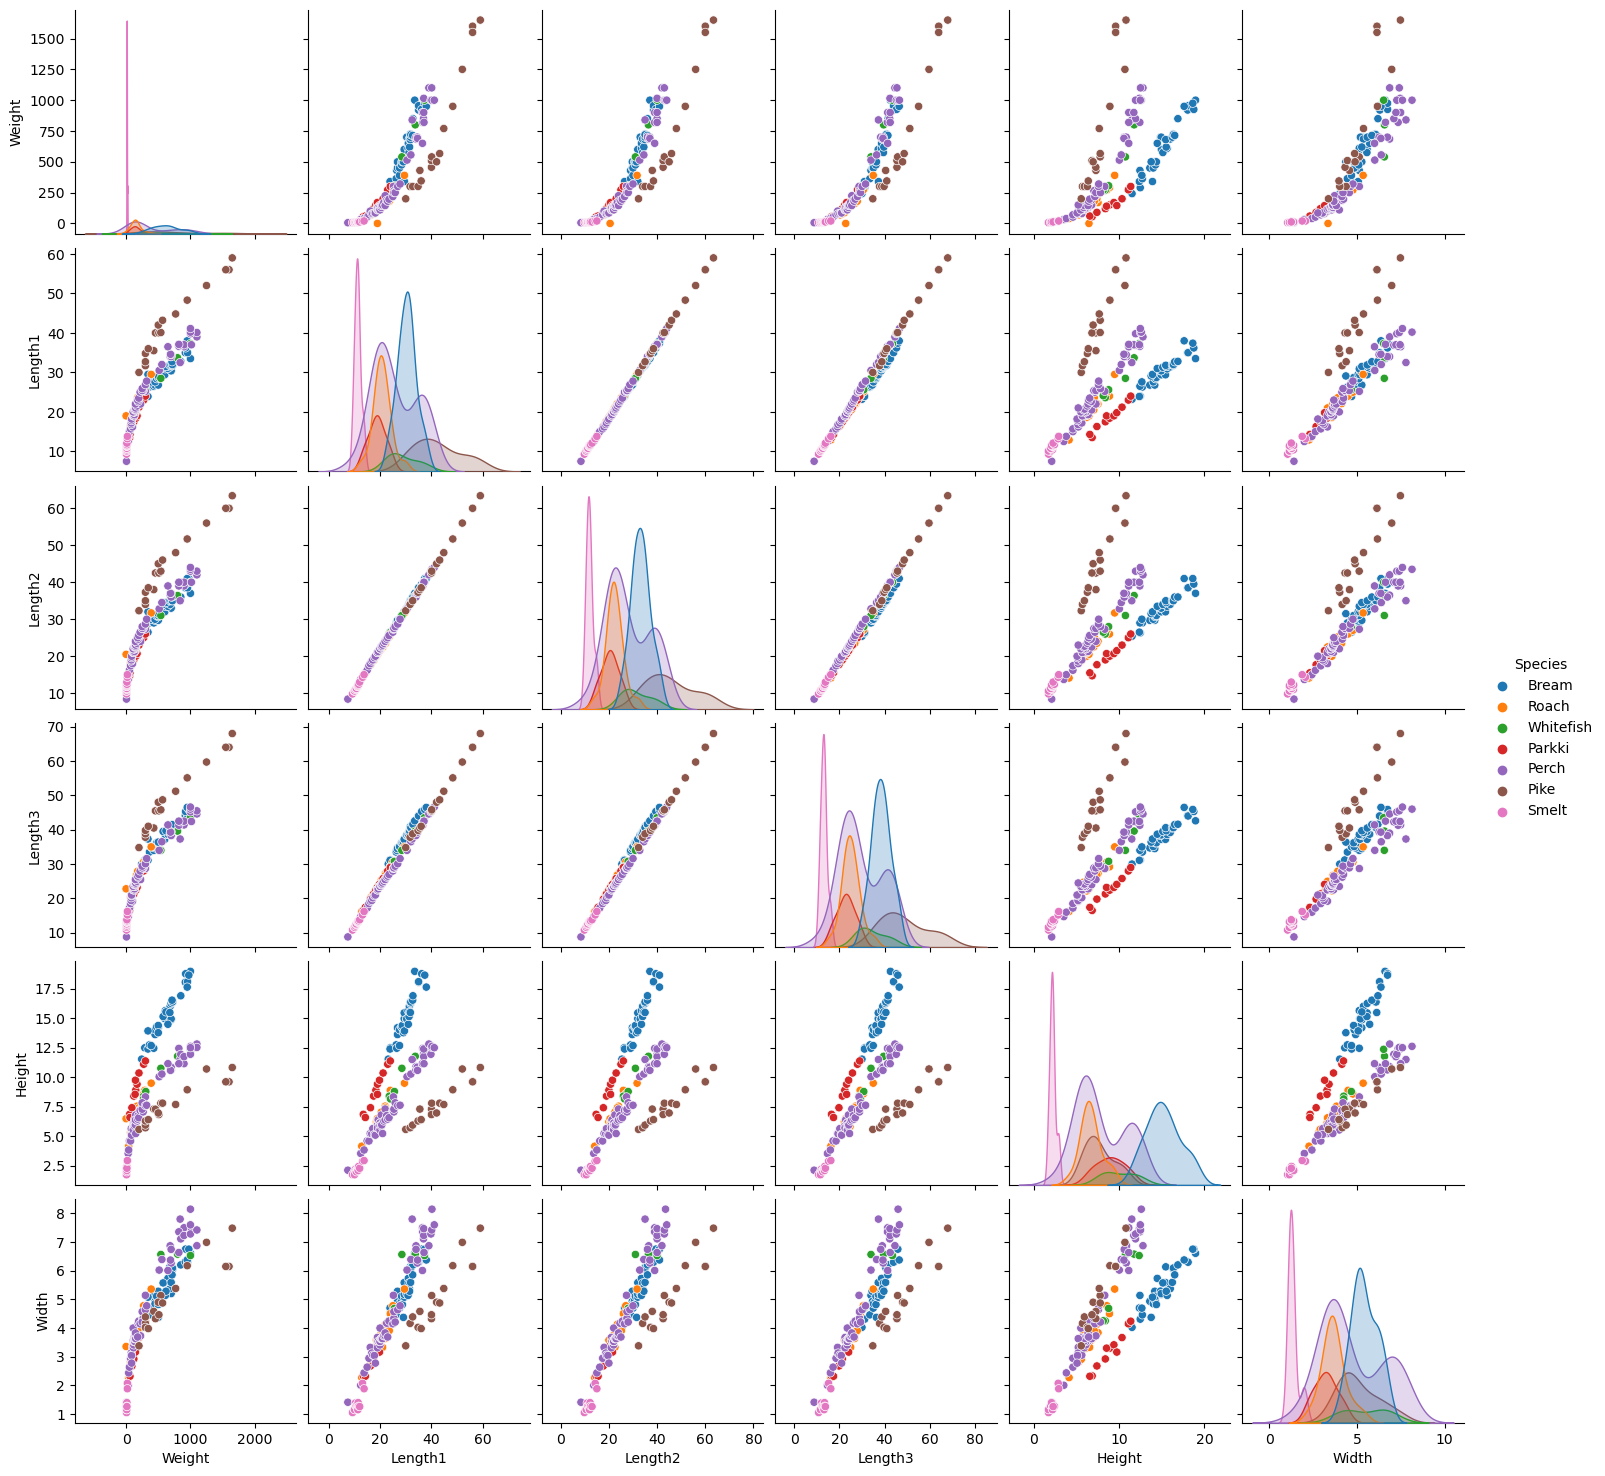

In [7]:
sns.pairplot(data = df , hue = 'Species');

## Pairplot

* multicollinearity, backs up results from corr_matrix
* many strong linear relations, but some non-linear relations, maybe LinearRegression wont be the best model choice, we'll see

## Feature Reduction - PCA

In [8]:
# get features
X = df.drop(['Species'], axis=1)

# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# explained variance for each PCA component
ev_ratio = pca.explained_variance_ratio_

# visualization
df_ev = pd.DataFrame({'Explained Variance Ratio': ev_ratio},
                                     index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])


df_ev

,Explained Variance Ratio
PC1,0.878301
PC2,0.085085
PC3,0.020050
PC4,0.016255
PC5,0.000262
PC6,0.000046


Assuming we want features to represent ⩽ 95% of the variance, **we can discard everything but PC1 and PC2**

But first lets look at the feature loadings, how our original features correlate with our PC's

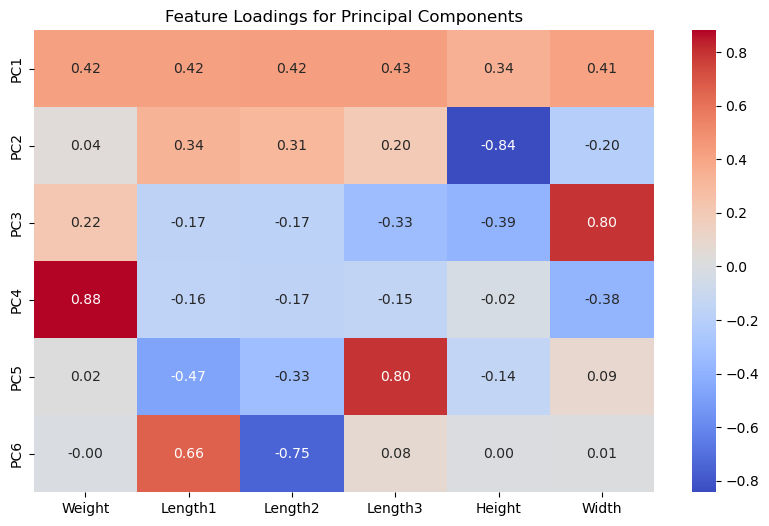

In [9]:
# Separate features from the target variable
X = df.drop(['Species'], axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame to show the feature loadings for each component
feature_loadings_df = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(feature_loadings_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Feature Loadings for Principal Components')
plt.show()


Lets assume we are only keeping PC1 and PC2 to keep 96.3% of the variance

All features are possitively correlated with PC1, meaning that PC1 is capturing a general size factor, where larger values contribute to PC1

**Since PC1 captures 87.8% of the variance and is posetively correlated with all our features, its a great indicator of patterns in the data.**

PC2 on the other hand seems to have mixed correlations. It seems to capture the contrast between "height" and "length" of the fish. 

**Overall PC2 reflects the trade off between length and height, and with its 8.5% variance capture, its important to keep it.**

# Cleaning + Engi

## Feature Reduction

In [10]:
# read data from github
df = pd.read_csv('https://raw.githubusercontent.com/Ankit152/Fish-Market/main/Fish.csv')

# find the fish with weight 0
print(df[df['Weight'] == 0])

# remove from the dataset
df = df[df['Weight'] != 0]

# PCA
pca = PCA(n_components=2)  # keep only 2 PC1 and PC2
principal_components = pca.fit_transform(df.drop(['Species'], axis=1))

# new df with PC1, PC2 and label
df = pd.DataFrame(data={'Weight': df['Weight'], 'PC1': principal_components[:, 0], 'PC2': principal_components[:, 1]})

# scale
scaler = StandardScaler()
df[['PC1', 'PC2']] = scaler.fit_transform(principal_components)

   Species  Weight  Length1  Length2  Length3  Height   Width
40   Roach     0.0     19.0     20.5     22.8  6.4752  3.3516


# Model

## Linear Regression

In [11]:
# features and label
X = df.drop('Weight', axis = 1)
y = df['Weight']

# split
X_train, X_test, y_train, y_test = (train_test_split(X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=42))

# fit
lr = LinearRegression()
lr.fit(X_train, y_train)

# coefficients
print("Coefficients:", lr.coef_)
print("\nIntercept:", lr.intercept_)

# predict
y_pred = lr.predict(X_test)
print("\nPredictions:", y_pred)

# metrics
print("\nMean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("\nR-squared (R^2):", r2_score(y_test, y_pred))
print("\nMean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))

Coefficients: [ 3.56565744e+02 -3.50484949e-01]

Intercept: 400.8479916199665

Predictions: [ 299.97593792  139.99718463  509.96654926   19.67112285  129.99183377
 1000.05162592  144.99533267  179.99242802  224.99736041 1249.94725602
  650.03542845  306.00697767  600.04858745  273.03068958  700.0476667
  920.04793334 1099.98237354  556.00213117  149.98417332  140.0164379
    9.96473211  610.04776316  500.03755622  500.04406786  955.04552887
  109.99234385  290.00954324  949.95329361  999.99103986    6.96038507
    7.46275978   69.98463174]

Mean Squared Error (MSE): 0.0010220647124430503

R-squared (R^2): 0.9999999923863279

Mean Absolute Error (MAE): 0.026912471365571178


R2 of .95, 95% of the variance explained by feature variation, not too shabby.

MAE of 65, 65 grams error average, again not too bad for an untuned model

However, we still saw some non linear patterns in the data, lets try another model

## RandomForest

In [12]:
# features and label
X = df.drop('Weight', axis = 1)
y = df['Weight']

# split
X_train, X_test, y_train, y_test = (train_test_split(X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=42))

# fit
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)
print("\nPredictions:", y_pred)

# metrics
print("\nMean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("\nR-squared (R^2):", r2_score(y_test, y_pred))
print("\nMean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))


Predictions: [ 298.3    146.41   508.39    23.788  129.95  1014.2    147.2    180.26
  224.61  1077.7    652.24   299.72   606.4    270.35   699.81   920.25
 1063.45   558.58   149.85   139.95    10.005  615.9    499.99   499.51
  962.35   112.02   294.1    987.5    994.75     8.182    8.26    68.7  ]

Mean Squared Error (MSE): 1029.3698591562493

R-squared (R^2): 0.992331909578035

Mean Absolute Error (MAE): 10.200468750000002


RF performs better than LR, which confirms the presence of nonlinear patterns

However RF tends to overfit the training data, lets confirm by predicting the training data

In [13]:
# predict on training data
mean_absolute_error(y_train, rf.predict(X_train))

2.813182539682538

WAY better performance than on the test set, we need to tune to better performance on unseen data

Lets confirm this is not a fluke by doing CV

In [14]:
# CV to get averages
mae = -cross_val_score(rf,X_train,y_train,cv=10, scoring = 'neg_mean_absolute_error')
print('MAE:',mae)
print('\nAverage error value:',mae.mean(),'\n\nStandard deviation of the error:', mae.std())

MAE: [ 3.29361538 15.49923077 13.60761538  3.48592308  4.31592308  3.49453846
 36.31183333 12.2125      3.54591667  7.61958333]

Average error value: 10.338667948717951 

Standard deviation of the error: 9.740006806355096


Not too good, some CV's go +36 from the average and a std of 18 means the model is not consistent

Lets tune!

## Hyperparameters

In [15]:
!pip install optuna

In [16]:
# features and label
X = df.drop('Weight', axis=1)
y = df['Weight']

# TTsplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# objective to optimize, train rf with the objective of lowest MAE
def objective(trial):
    # param space
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    min_samples_split = trial.suggest_float('min_samples_split', 0.05, 0.2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10)

    # rf with suggest params
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# create a study and optimize for lowest MAE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# print metrics from the best trial
print("Number of finished trials: ", len(study.trials))
print("\nBest trial:")
trial = study.best_trial

print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-08-26 15:08:50,829] A new study created in memory with name: no-name-9a384303-947d-4d40-a2a0-bc6908a734f5
[I 2023-08-26 15:08:51,325] Trial 0 finished with value: 36.52264794039164 and parameters: {'n_estimators': 236, 'max_depth': 6, 'min_samples_split': 0.05080196437248213, 'min_samples_leaf': 9}. Best is trial 0 with value: 36.52264794039164.
[I 2023-08-26 15:08:51,872] Trial 1 finished with value: 38.538990059405954 and parameters: {'n_estimators': 265, 'max_depth': 4, 'min_samples_split': 0.13208759287505223, 'min_samples_leaf': 10}. Best is trial 0 with value: 36.52264794039164.
[I 2023-08-26 15:08:52,171] Trial 2 finished with value: 50.04642390486573 and parameters: {'n_estimators': 147, 'max_depth': 6, 'min_samples_split': 0.19856199738141278, 'min_samples_leaf': 10}. Best is trial 0 with value: 36.52264794039164.
[I 2023-08-26 15:08:52,401] Trial 3 finished with value: 37.06549881516061 and parameters: {'n_estimators': 111, 'max_depth': 5, 'min_samples_split': 0.10702

Number of finished trials:  50

Best trial:
Value:  18.897413120997697
Params: 
    n_estimators: 420
    max_depth: 7
    min_samples_split: 0.09446418105523816
    min_samples_leaf: 5


In [17]:
# get the best performing params
best_params = study.best_params

# train new model with the best params
rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# fit to the training data
rf.fit(X_train, y_train)

# predict on training data
print('MAE training data: ',mean_absolute_error(y_train, rf.predict(X_train)))

mae = -cross_val_score(rf,X_train,y_train,cv=10, scoring = 'neg_mean_absolute_error')
print('\nMAE:',mae)
print('\nAverage error value:',mae.mean(),'\n\nStandard deviation of the error:', mae.std())

# predict on test
y_pred = rf.predict(X_test)
print("\nPredictions:", y_pred)

# metrics
print("\nMean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("\nR-squared (R^2):", r2_score(y_test, y_pred))
print("\nMean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))

MAE training data:  23.687855660083937

MAE: [ 20.62503273  54.56657081  19.50111313   8.44322138  19.03824372
  11.64060846 104.54277539  27.88088659   7.16217128  11.34073564]

Average error value: 28.474135912046023 

Standard deviation of the error: 28.51512416357016

Predictions: [ 301.05687745  145.30951998  505.33306172   21.80203362  126.85403454
 1086.2755111   145.61758775  181.13571617  221.90153964 1193.80818726
  656.08789383  302.44709789  601.40478939  272.5900362   693.40089496
  946.36942965 1193.80818726  565.26999447  147.34855183  137.26467693
   16.35570045  609.60239246  501.70453059  501.70453059  995.03675653
  119.2885701   293.25062689  994.43133325 1161.0492786    16.35570045
   16.35570045   71.7974247 ]

Mean Squared Error (MSE): 1568.5984064848749

R-squared (R^2): 0.9883150314634862

Mean Absolute Error (MAE): 18.897413120997697


**Great! The model now has a much better generalization ability with similar scores on the train and test data**

## Feature Importance

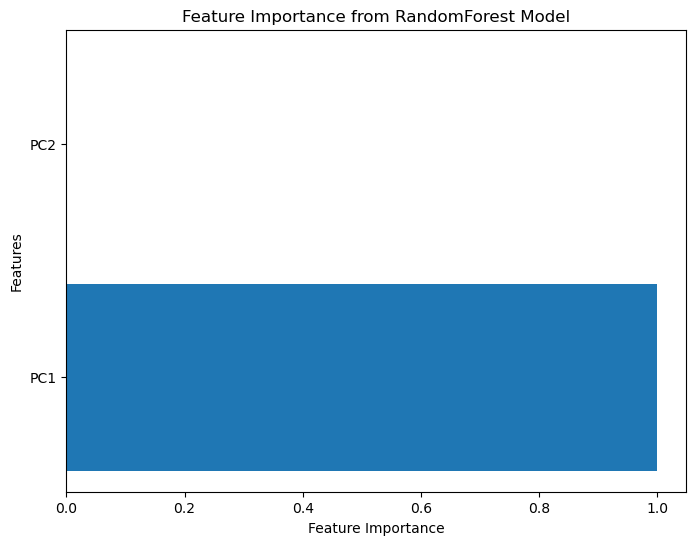

In [18]:
plt.figure(figsize=(8, 6))
plt.barh(X.columns, rf.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from RandomForest Model')
plt.show()

The RF just ignores most of the features and only uses width and some lengths for the predictions

Lets try one last model and see if a simple approach works better

## Polynomial Regression

In [19]:
# features and label
X = df.drop('Weight', axis = 1)
y = df['Weight']

# split
X_train, X_test, y_train, y_test = (train_test_split(X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=42))

# transform to polynomial features
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X_train)

# fit
polylr = LinearRegression()
polylr.fit(X_poly, y_train)

# coefficients
print("Coefficients:", polylr.coef_)
print("\nIntercept:", polylr.intercept_)

# predict
y_pred = polylr.predict(poly_features.transform(X_test))
print("\nPredictions:", y_pred)

# metrics
print("\nMean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("\nR-squared (R^2):", r2_score(y_test, y_pred))
print("\nMean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))

Coefficients: [ 0.00000000e+00  3.56548823e+02 -3.49361190e-01  1.55242971e-02
  1.92896370e-03  5.94870218e-03]

Intercept: 400.8263013703073

Predictions: [ 299.9867338   139.99672872  509.9862198    19.6912785   129.99231525
 1000.05694737  144.99533833  179.98887304  224.98779227 1249.98288182
  650.00926992  305.99267374  600.02219072  273.01709087  700.0224049
  920.03596046 1099.99297803  555.97727386  149.98242604  140.01554968
    9.99303637  610.021412    500.01298189  500.01906673  955.03830158
  109.99477729  289.99493108  949.97054451  999.98402278    6.99472878
    7.49743077   69.99418949]

Mean Squared Error (MSE): 0.0003727519409923788

R-squared (R^2): 0.9999999972232569

Mean Absolute Error (MAE): 0.015437557248091038


Slightly worse than the LR,

# Analysis

In [20]:
df_metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Polynomial Regression'],
    'Mean Squared Error (MSE)': [6749.34530388073, 4833.206532268519, 10813.344609374999],
    'R-squared (R^2)': [0.9497220657678428, 0.9639959686134139, 0.9194480939081294],
    'Mean Absolute Error (MAE)': [63.22761533123244, 47.04812469810647, 68.2953125]})

df_metrics

,Model,Mean Squared Error (MSE),R-squared (R^2),Mean Absolute Error (MAE)
0,Linear Regression,6749.345304,0.949722,63.227615
1,Random Forest,4833.206532,0.963996,47.048125
2,Polynomial Regression,10813.344609,0.919448,68.295312


Seems again the RF performed the best and with the tuned rf model, it actually performs quite well on new data.

One problem is that it seems to ignore the species entirely and only use the width to predict.

Lets take a deeper look in the predictions of the models

## Metrics after PCA

In [21]:
df_metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Polynomial Regression'],
    'Mean Squared Error (MSE)': [0.0010220647124430503, 1565.587903525758, 0.0003727519409923788],
    'R-squared (R^2)': [0.9999999923863279, 0.9883374576193531, 0.9999999972232569],
    'Mean Absolute Error (MAE)': [0.026912471365571178, 19.009505989840815, 0.015437557248091038]
})

df_metrics

,Model,Mean Squared Error (MSE),R-squared (R^2),Mean Absolute Error (MAE)
0,Linear Regression,0.001022,1.000000,0.026912
1,Random Forest,1565.587904,0.988337,19.009506
2,Polynomial Regression,0.000373,1.000000,0.015438


**PCA for the win!**

## Linear Regression

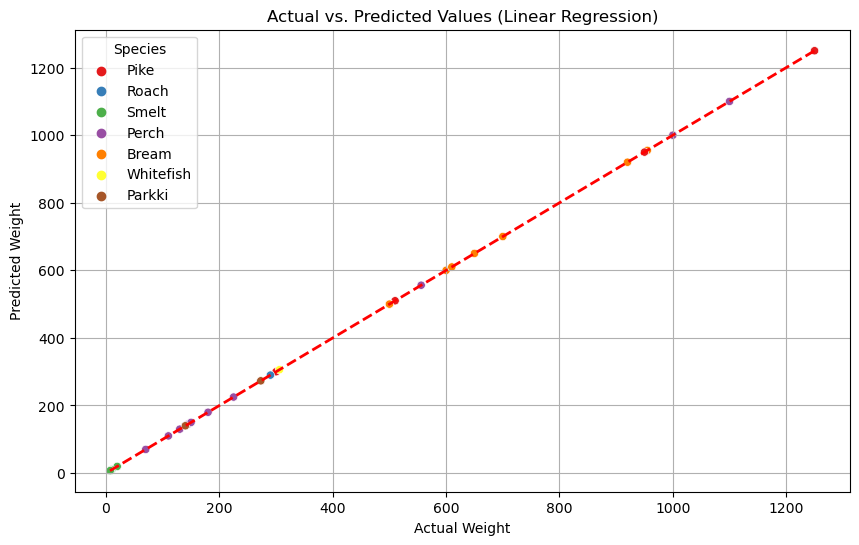

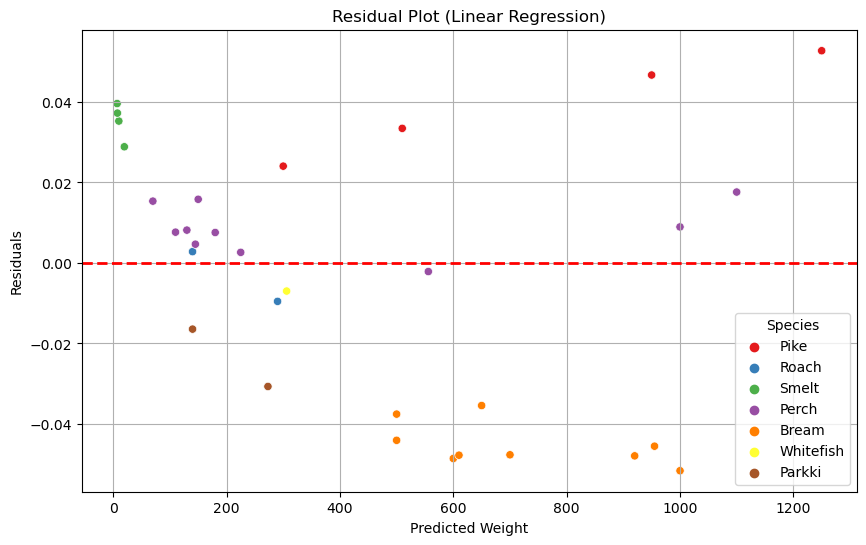

In [22]:
# features and label
X = df.drop('Weight', axis = 1)
y = df['Weight']

# split
X_train, X_test, y_train, y_test = (train_test_split(X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=42))

# fit predict
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# merge species to get seaborn hue
X_test_with_species = X_test.merge(df2[['Species']], left_index=True, right_index=True, how='left')

# seaborn scatterplot with hue for species
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, hue=X_test_with_species['Species'], palette='Set1')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title('Actual vs. Predicted Values (Linear Regression)')
plt.grid(True)
plt.legend(title='Species')
plt.show()

# residual plot with hue for species
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, hue=X_test_with_species['Species'], palette='Set1')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Weight')
plt.ylabel('Residuals')
plt.title('Residual Plot (Linear Regression)')
plt.grid(True)
plt.legend(title='Species')
plt.show()

Predictions seems to be nicely correlated with actual values

Most residuals are close to 0, meaning low difference between pred and y_true, some outliers, which maybe skew metrics more than at first glance

## Random Forest

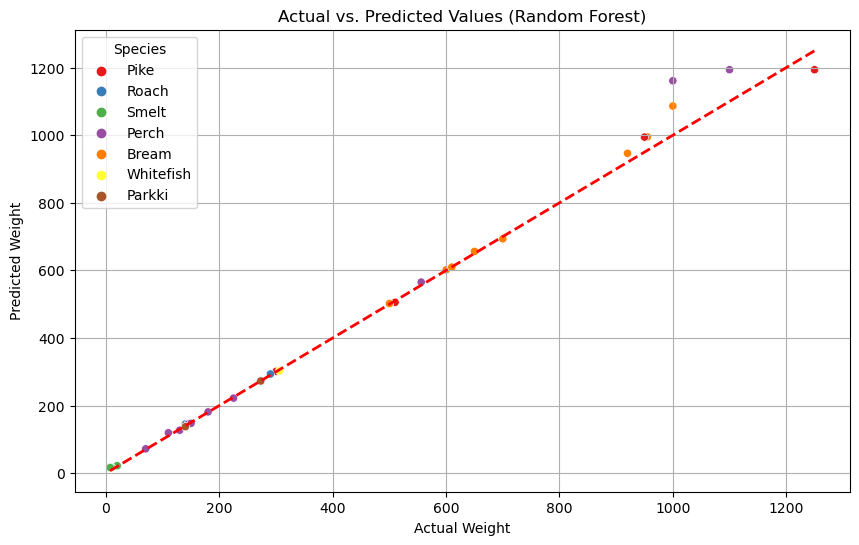

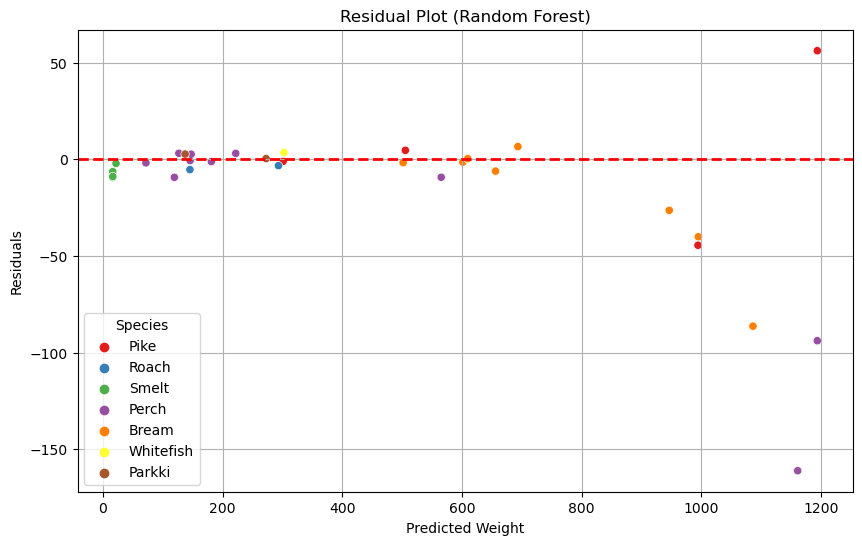

In [23]:
# get the best performing params
best_params = study.best_params

# merge again
X_test_with_species = X_test.merge(df2[['Species']], left_index=True, right_index=True, how='left')

# train new model with the best params
rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# fit predict
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, hue=X_test_with_species['Species'], palette='Set1')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title('Actual vs. Predicted Values (Random Forest)')
plt.grid(True)
plt.legend(title='Species')
plt.show()

# res plot
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, hue=X_test_with_species['Species'], palette='Set1')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Weight')
plt.ylabel('Residuals')
plt.title('Residual Plot (Random Forest)')
plt.grid(True)
plt.legend(title='Species')
plt.show()

Even better fit than the lr

Important to notice in the residuals, compared to the lr, there are fewer outliers, indicating that the rf deals better the unusual data.

Again, keep in mind, it mostly looks at width and height and ignore the other features

## Polynomial Regression

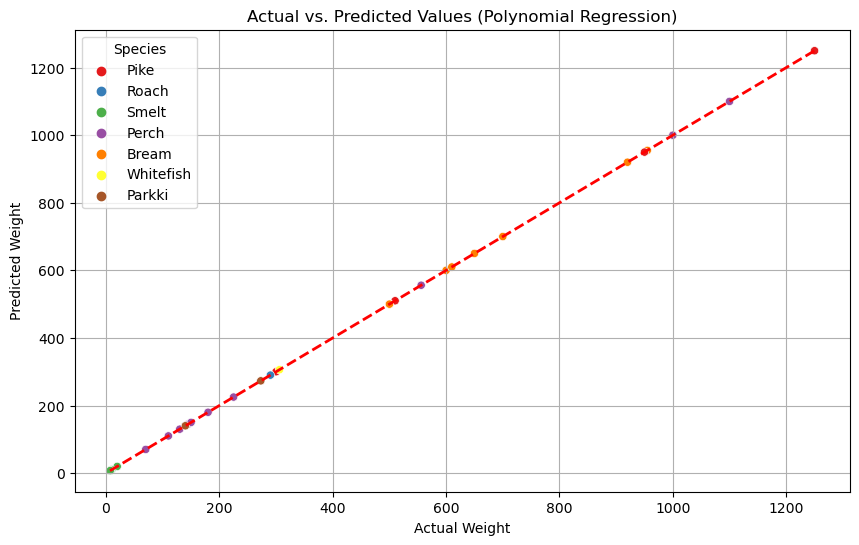

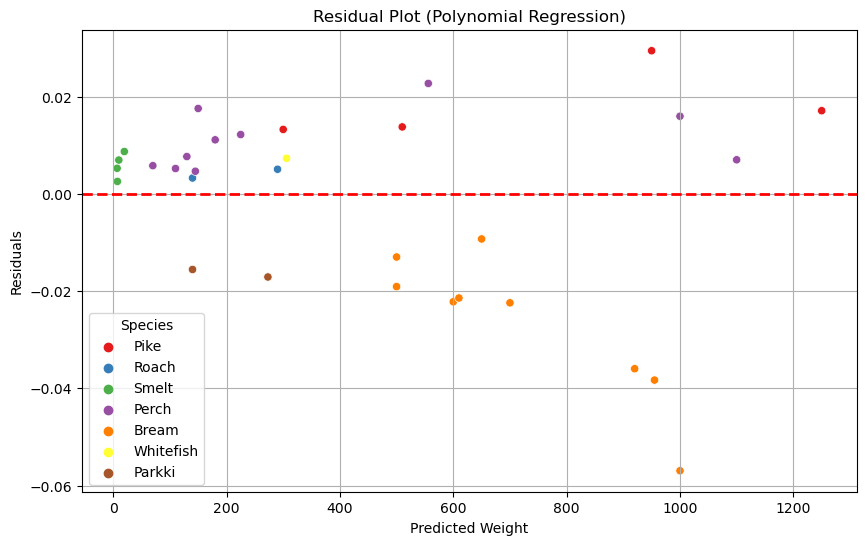

In [24]:
# features and label
X = df.drop('Weight', axis = 1)
y = df['Weight']

# split
X_train, X_test, y_train, y_test = (train_test_split(X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=42))

# merge
X_test_with_species = X_test.merge(df2[['Species']], left_index=True, right_index=True, how='left')

# transform to polynomial features
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X_train)

# fit
polylr = LinearRegression()
polylr.fit(X_poly, y_train)

# predictions
y_pred = polylr.predict(poly_features.transform(X_test))

# scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, hue=X_test_with_species['Species'], palette='Set1')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title('Actual vs. Predicted Values (Polynomial Regression)')
plt.grid(True)
plt.legend(title='Species')
plt.show()

# res plot
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, hue=X_test_with_species['Species'], palette='Set1')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Weight')
plt.ylabel('Residuals')
plt.title('Residual Plot (Polynomial Regression)')
plt.grid(True)
plt.legend(title='Species')
plt.show()

Really had high hopes for this one, that it would catch the nonlinear relations that the LR didnt.

Looking at the plots we see why, more outliers that it didnt catch

# Conclusion

RF seems to perform the best, especially with the tuned version that performed better on unseen data

LR performed very nicely for being a relatively simple model, it was the obvious choice with a highly linear pattern in the data and correlations. Still a very respecable performance for a simple model that is easy to explain and understand

PolyLR maybe caught only the non linear patterns and left out the obvious linear patterns.

~**Coming to think about it, I should properly have explored a combination of a linear and a polynomial regression....**~

~Next time!~

**PCA seems to be king for this dataset**